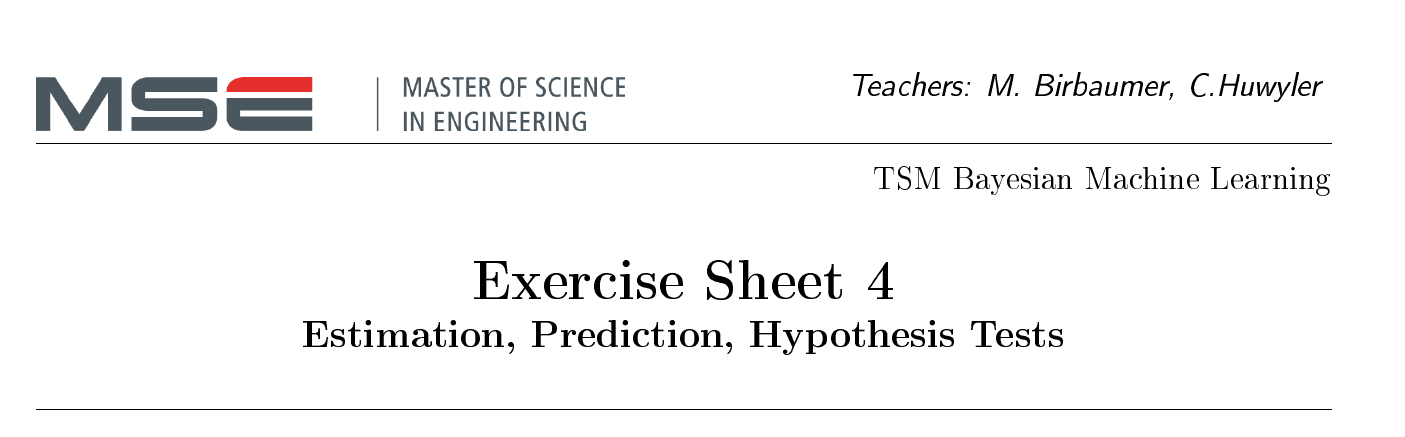

# Solutions

Import necessary libraries:

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
from tqdm.auto import tqdm
import pymc as pm

plt.rcParams["figure.figsize"] = (15, 3)
plt.style.use('ggplot')
np.random.seed(1337)  # for consistency

## Exercise 1

Data:

In [4]:
beds = np.array(
    [6, 11, 12, 9, 11, 10, 9, 18, 9, 18, 12, 14, 9, 11, 10, 15, 13, 11, 14, 12, 11, 8, 11, 13, 11, 12, 20, 5, 13, 16])

### a)

In [5]:
np.mean(beds)

11.8

In [6]:
np.var(beds)

10.76

Variance and mean are (more or less) similar, let's proceed with a Poisson distribution.

### b)

$E[\lambda] = \frac{s}{r} = 15 \Rightarrow s = 15r$

Experiment until approximately variance from exercise description is reached:

<Axes: >

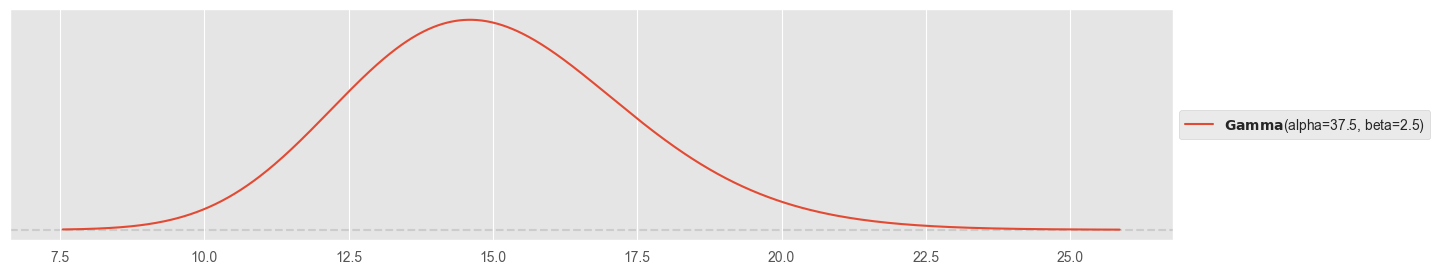

In [7]:
r = 2.5
s = 15 * r
pz.Gamma(s, r).plot_pdf()

### c)

Sample only from prior:

In [8]:
with pm.Model() as maternity_ward_model:
    lbd = pm.Gamma('lbd', alpha=s, beta=r)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


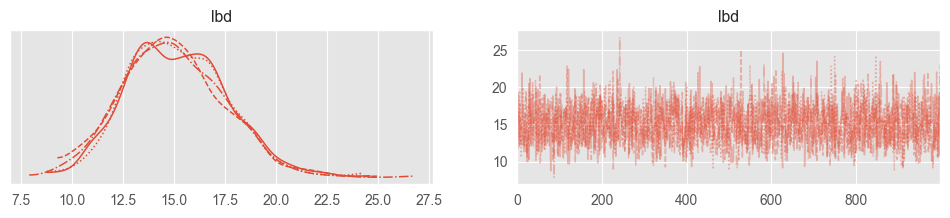

In [9]:
pm.plot_trace(trace);

Looks as defined!

### d)

Full model:

In [10]:
with pm.Model() as maternity_ward_model:
    lbd = pm.Gamma('lbd', alpha=s, beta=r)
    y = pm.Poisson('y', mu=lbd, observed=beds)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Trace and density plot:

array([[<Axes: title={'center': 'lbd'}>,
        <Axes: title={'center': 'lbd'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

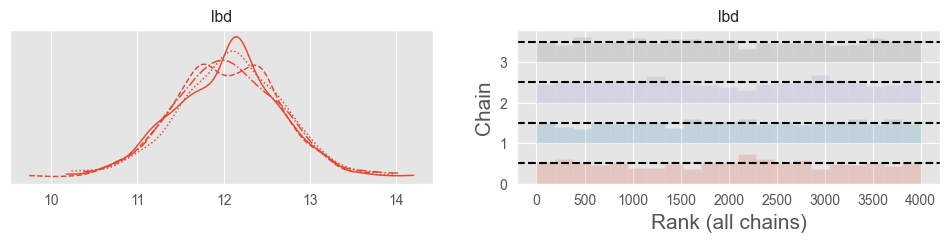

In [11]:
pm.plot_trace(trace, kind="rank_bars")

Autocorrelation plot:

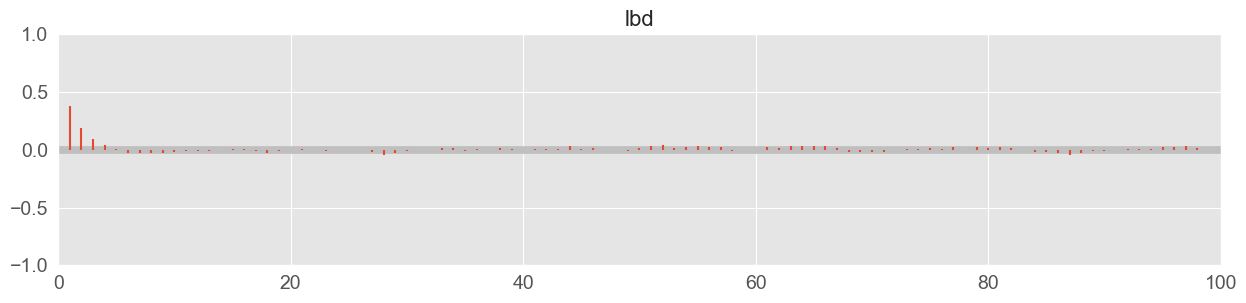

In [12]:
pm.plot_autocorr(trace, combined=True);

In [13]:
pm.rhat(trace)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    lbd      float64 8B 1.001

In [14]:
pm.ess(trace)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    lbd      float64 8B 1.659e+03

Looks nominal!

### e)

<Axes: title={'center': 'lbd'}>

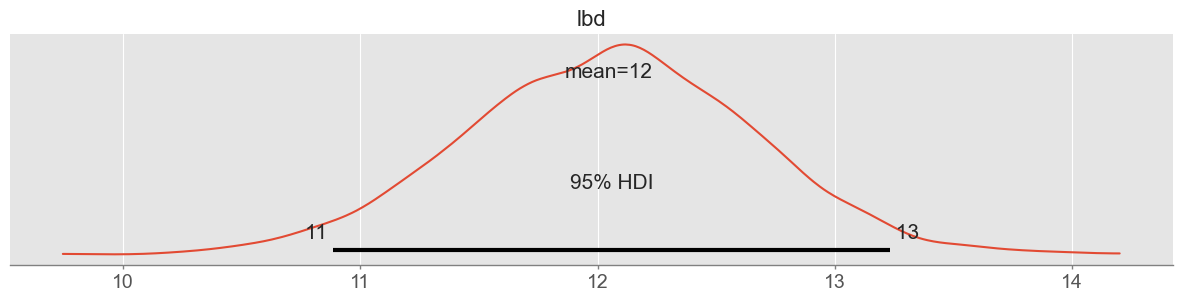

In [15]:
pm.plot_posterior(trace, hdi_prob=0.95)

In [16]:
pm.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lbd,12.046,0.603,10.885,13.233,0.015,0.01,1659.0,2542.0,1.0


"After considering the 30 measurements, I believe to 95% that the **mean** number of beds used per night is somewhere between 10.8 and 13.2, if I had to guess a number, I would say 12.1. The standard deviation is quite small with $\pm$0.6 beds. However the mean only reflects my model knowledge, but not my predictions!"

### f)

In [17]:
with maternity_ward_model:
    y_new = pm.Poisson('y_new', mu=lbd)
    predictions = pm.sample_posterior_predictive(trace, var_names=["y_new"])

Sampling: [y_new]


Output()

In [18]:
365 * np.mean(predictions.posterior_predictive.y_new > 20).values

5.38375

Around 4-5 days per year!

### g)

In [19]:
aleatoric_var = np.mean(trace.posterior.lbd.values)
epistemic_var = np.var(trace.posterior.lbd.values)
pred_var = np.var(predictions.posterior_predictive.y_new.values)
np.round(np.array([aleatoric_var, epistemic_var]) / (aleatoric_var + epistemic_var) * 100, 1)

array([97.1,  2.9])

Aleatoric variance makes up 97%. More data will not yield much improvement here!

## Exercise 2

In [20]:
y_b_obs = np.array([181, 152, 148, 146, 171])
y_a_obs = np.array([163, 153, 146, 126, 142])

### a)

In [21]:
with pm.Model() as railway_counter_queue_model:
    μ_b = pm.Normal('μ_b', mu=np.mean(y_b_obs), sigma=np.std(y_b_obs, ddof=1))
    μ_a = pm.Normal('μ_a', mu=np.mean(y_a_obs), sigma=np.std(y_a_obs, ddof=1))
    σ_b = pm.Exponential('σ_b', lam=1 / np.std(y_b_obs, ddof=1))
    σ_a = pm.Exponential('σ_a', lam=1 / np.std(y_a_obs, ddof=1))
    y_b = pm.Normal('y_b', mu=μ_b, sigma=σ_b, observed=y_b_obs)
    y_a = pm.Normal('y_a', mu=μ_a, sigma=σ_a, observed=y_a_obs)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_b, μ_a, σ_b, σ_a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Check chain quickly:

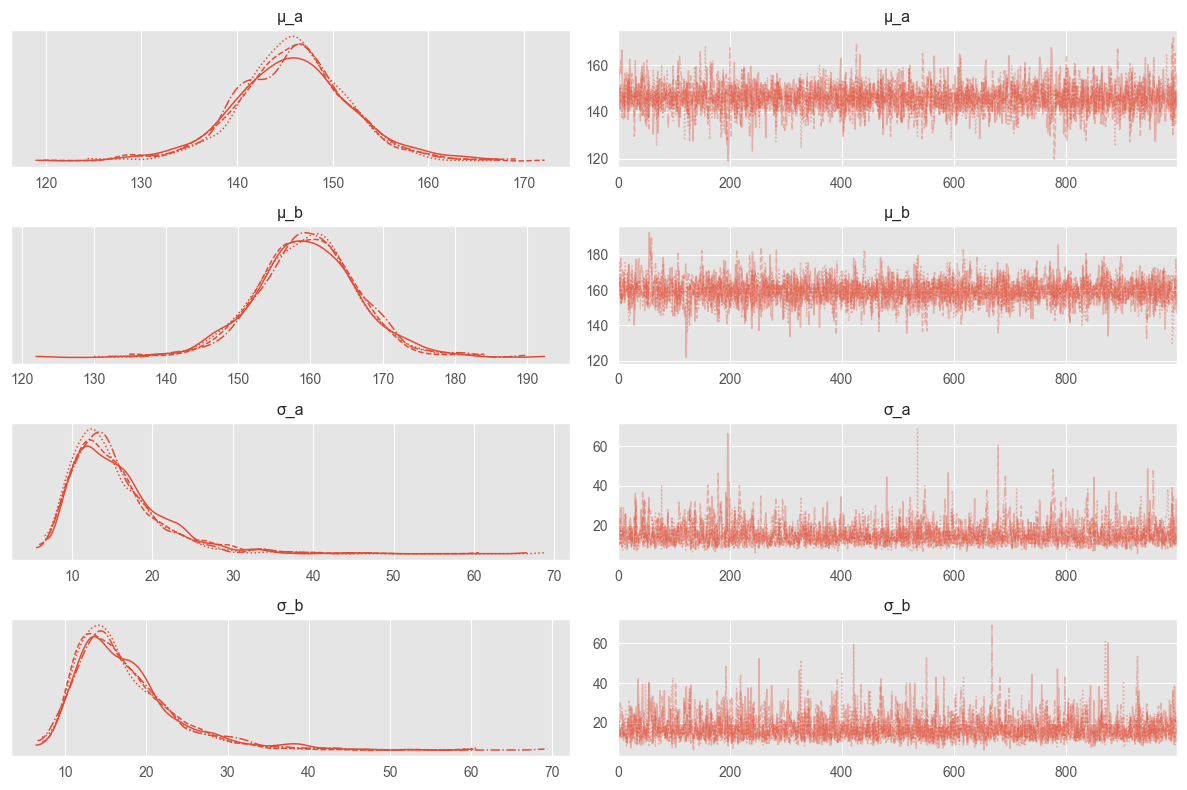

In [22]:
pm.plot_trace(trace)
plt.tight_layout()

Looks good!

### b)

<Axes: title={'center': 'x'}>

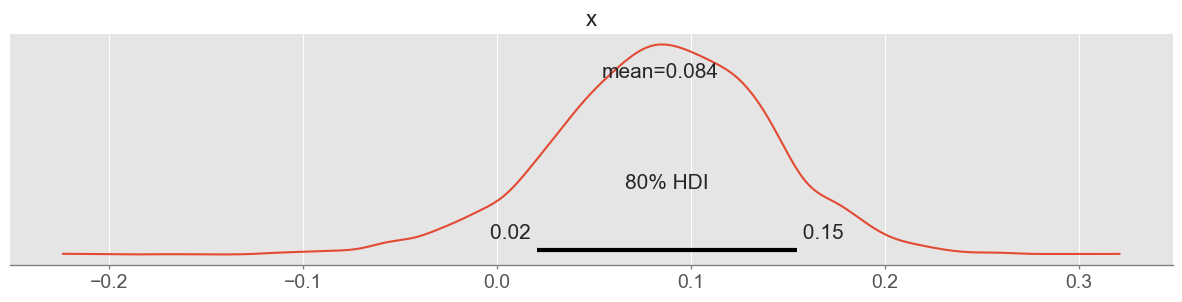

In [23]:
reldiff = (trace.posterior.μ_b - trace.posterior.μ_a) / trace.posterior.μ_b
pm.plot_posterior(reldiff, hdi_prob=0.8)

In [24]:
pm.hdi(reldiff, hdi_prob=0.8).x.values

array([0.02034498, 0.15474466])

With a plausibility of 80%, about 1-15% toilet paper mass less is used! This does not appear very certain and more data will be needed for a better number. However it is already now quite clear that likely the weekly mass of toilet paper used was reduced.

### c)

* $H_1$: $(\mu_b - \mu_a)/\mu_b \geq 20$%
* $H_2$: $(\mu_b - \mu_a)/\mu_b < 20$%

In [25]:
PH1d = np.mean(reldiff.values >= 0.2)
PH1d

0.01375

In [26]:
PH2d = 1 - PH1d
PH2d

0.98625

In [27]:
posterior_odds = PH1d / PH2d
posterior_odds

0.01394169835234474

Given the measured data, the odds for his hypothesis are very small!

### d)

In [28]:
np.mean(reldiff.values >= 0.1)

0.393

Only around 37%! The value might as well be smaller!

### e)

Make predictions:

In [29]:
with maternity_ward_model:
    y_new_b = pm.Normal('y_new_b', mu=μ_b, sigma=σ_b)
    y_new_a = pm.Normal('y_new_a', mu=μ_a, sigma=σ_a)
    predictions = pm.sample_posterior_predictive(trace, var_names=["y_new_b", "y_new_a"])

Sampling: [y_new_a, y_new_b]


Output()

Approximate aleatoric and epistemic variances:

In [30]:
aleatoric_var_b = np.mean(trace.posterior.σ_b.values ** 2)
epistemic_var_b = np.var(trace.posterior.μ_b.values)
aleatoric_var_a = np.mean(trace.posterior.σ_a.values ** 2)
epistemic_var_a = np.var(trace.posterior.μ_a.values)

Compute proportions:

In [31]:
np.round(np.array([aleatoric_var_b, epistemic_var_b]) / (aleatoric_var_b + epistemic_var_b) * 100, 1)

array([87.2, 12.8])

In [32]:
np.round(np.array([aleatoric_var_a, epistemic_var_a]) / (aleatoric_var_a + epistemic_var_a) * 100, 1)

array([88.2, 11.8])

The proportions are very similar! They indicate that most of the variance is already aleatoric, so more data will make it a little bit clearer, but not so much.

## Exercise 3

### a)

Prior:

<Axes: >

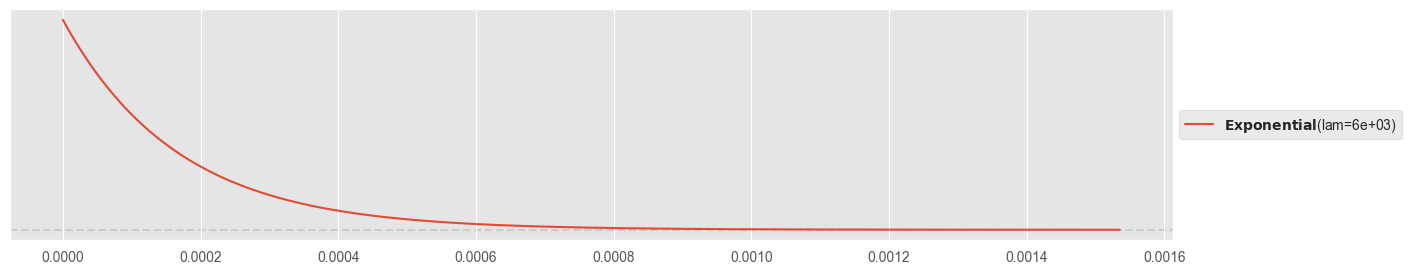

In [33]:
mean_rate = 5 / 30000
pz.Exponential(lam=1 / mean_rate).plot_pdf()

### b)

Run simulation:

In [34]:
with pm.Model() as defective_screw_model:
    pi = pm.Exponential('pi', lam=1 / mean_rate)
    y = pm.Binomial('y', n=30000, p=pi, observed=5)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Diagnostics:

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

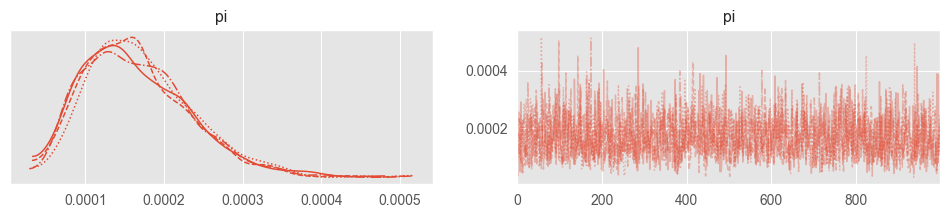

In [35]:
pm.plot_trace(trace)

<Axes: title={'center': 'pi'}>

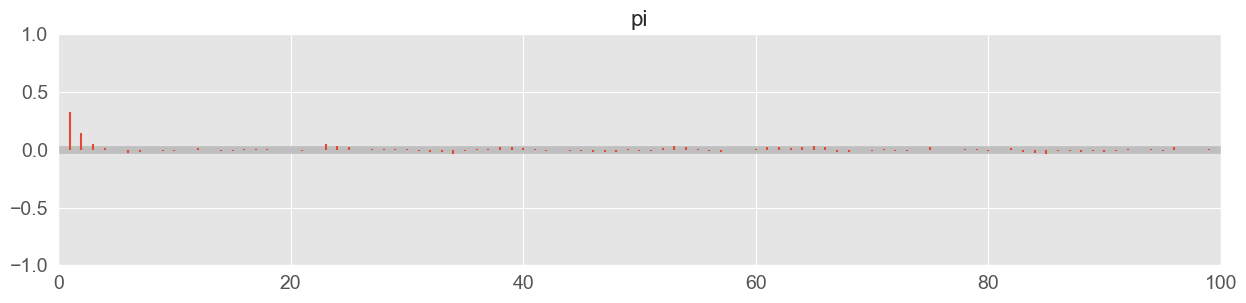

In [36]:
pm.plot_autocorr(trace, combined=True)

Looks good!

Visualize posterior:

<Axes: title={'center': 'pi'}>

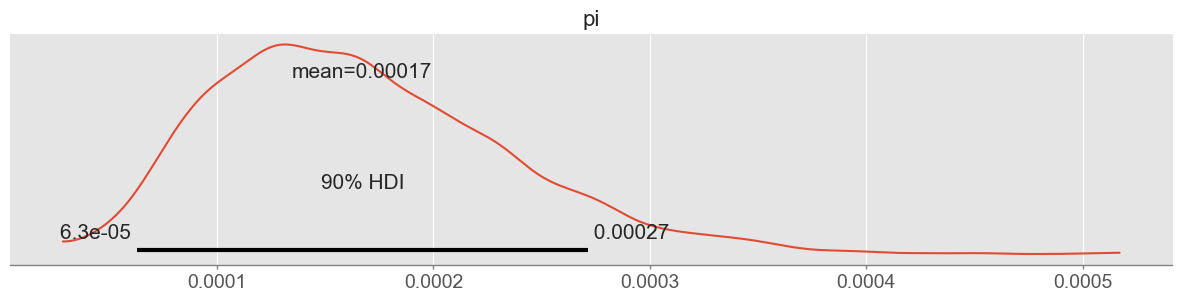

In [37]:
pm.plot_posterior(trace, hdi_prob=0.9)

In [38]:
pm.hdi(trace, hdi_prob=0.9).pi.values

array([6.29340621e-05, 2.71366346e-04])

90% HDI is between 6 in 100'000 and 2.7 in 1000. There is still quite some uncertainty!

### c)

In [39]:
with defective_screw_model:
    y_new = pm.Binomial('y_new', n=30000, p=pi)
    predictions = pm.sample_posterior_predictive(trace, var_names=["y_new"])

Sampling: [y_new]


Output()

<Axes: title={'center': 'y_new'}>

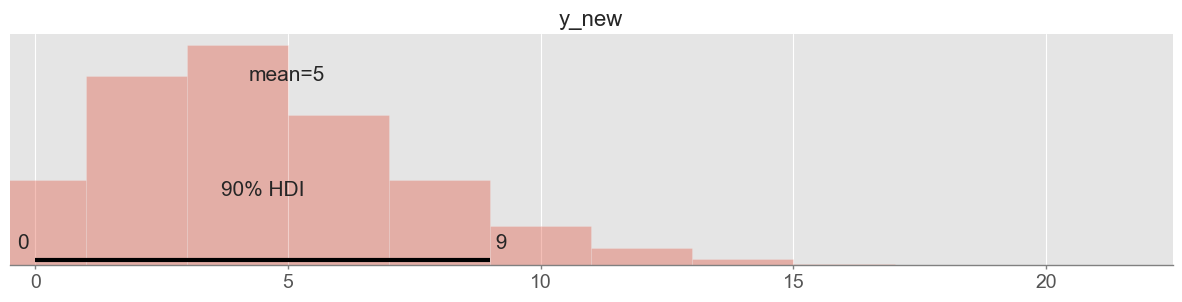

In [40]:
pm.plot_posterior(predictions.posterior_predictive.y_new, hdi_prob=0.9)

In [41]:
pm.hdi(predictions.posterior_predictive.y_new, hdi_prob=0.9).y_new.values

array([0., 9.])

Within the next 30 days, I believe to 90% that between 0-9 screws will be defective.

Aleatoric and epistemic uncertainty:

In [42]:
n_new = 30000
aleatoric_vars = n_new * trace.posterior.pi.values * (1 - trace.posterior.pi.values)
aleatoric_var = np.mean(aleatoric_vars)
aleatoric_var

5.004791600330783

In [43]:
epistemic_var = np.var(trace.posterior.pi.values * n_new)
epistemic_var

4.194208434152157

Looks like there is the same amount of epistemic variance and aleatoric variance - more data should improve the predictions.

Check: Real predictive uncertainty vs theoretical one:

In [44]:
predictive_var = np.var(predictions.posterior_predictive.y_new.values)
predictive_var, aleatoric_var + epistemic_var

(9.074612437500004, 9.199000034482939)

### d)

Re-run simulation with more data:

In [45]:
with pm.Model() as defective_screw_model2:
    pi = pm.Exponential('pi', lam=1 / mean_rate)
    y = pm.Binomial('y', n=60000, p=pi, observed=8)
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Visualize posterior belief for proportion $\pi$:

<Axes: title={'center': 'pi'}>

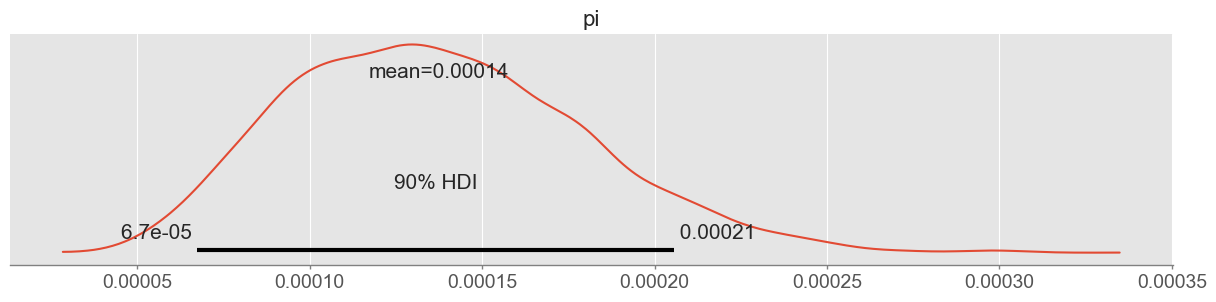

In [46]:
pm.plot_posterior(trace2, hdi_prob=0.9)

In [47]:
pm.hdi(trace2, hdi_prob=0.9).pi.values

array([6.74440780e-05, 2.05758422e-04])

90% HDI changed to between 7 in 10000 and 2 in 1000. In particular the upper bound is considerably lower.

Prediction for the next 30 days:

In [48]:
with defective_screw_model2:
    y_new = pm.Binomial('y_new', n=30000, p=pi)
    predictions2 = pm.sample_posterior_predictive(trace2, var_names=["y_new"])

Sampling: [y_new]


Output()

<Axes: title={'center': 'y_new'}>

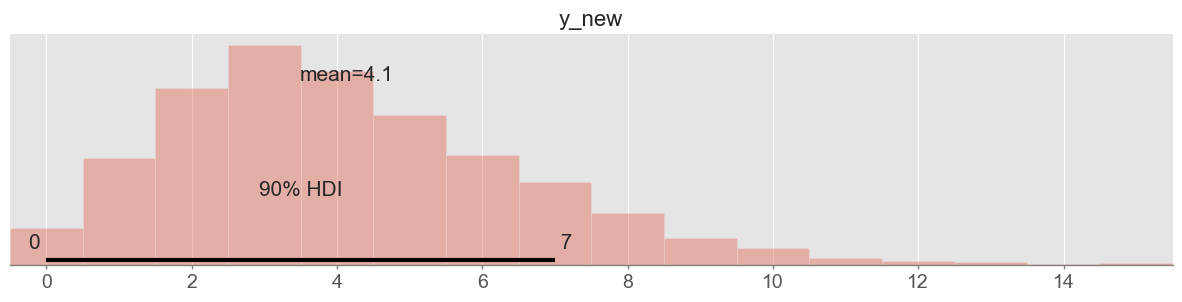

In [49]:
pm.plot_posterior(predictions2.posterior_predictive.y_new, hdi_prob=0.9)

In [50]:
pm.hdi(predictions2.posterior_predictive.y_new, hdi_prob=0.9).y_new.values

array([0., 7.])

Within the next 30 days, I believe to 90% that between 0-7 screws will be defective. There is still considerable uncertainty.

Aleatoric and epistemic uncertainty for 30 days prediction:

In [51]:
n_new = 30000
aleatoric_vars = n_new * trace2.posterior.pi.values * (1 - trace2.posterior.pi.values)
aleatoric_var = np.mean(aleatoric_vars)
aleatoric_var

4.125315528607253

In [52]:
epistemic_var = np.var(trace2.posterior.pi.values * n_new)
epistemic_var

1.7635488547042963

Proportions:

In [53]:
np.array([aleatoric_var, epistemic_var]) / (aleatoric_var + epistemic_var)

array([0.70052819, 0.29947181])

Check:

In [54]:
predictive_var = np.var(predictions2.posterior_predictive.y_new.values)
predictive_var, aleatoric_var + epistemic_var

(5.972412437500001, 5.8888643833115495)

**Note:** Because the predicted numbers and the involved uncertainties are low and of about the same magnitude, comparing aleatoric and epistemic uncertainty can also be misleading here. You can play around with this by e.g. assuming that 12 screws of 60'000 were defective instead of 8.

## Exercise 4

We find $P(D|H_0) = \frac{1}{36}$ and $P(D|H_1) = \frac{35}{36}$. If the Sun has really exploded, the detector will return a positive detection (not lie to us) with a probability of $1-\frac{1}{36} = \frac{35}{36}$, if the Sun has not exploded the detector will return a positive detection (lie to us) with a probability of $\frac{1}{36}$.

Hence we find a Bayes factor for the alternative hypothesis of

$$
\frac{P(D|H_1)}{P(D|H_0)} = 35
$$

and consequently

$$
\frac{P(H_1|D)}{P(H_0|D)} = 35 \; \frac{P(H_1)}{P(H_0)}.
$$

If we used equal prior probabilities for $H_1$ and $H_0$, this would be overwhelming, but since it is reasonable to believe that $H_0$ is much less likely than $H_1$, we shouldn't let us convince from this Bayes factor.